# Learning a graphon 

In [1]:
import logging
import os
import sys
import warnings
import itertools as it
from time import perf_counter
from numpy.random import default_rng
def append_path(s):
    if s in sys.path:
        return
    sys.path.append(s)
    
#You don’t need those lines if you installed the packages
append_path("/home/tristan/research/ot_markov_distances/")
append_path("/home/tristan/research/tb_ml/")
append_path("/home/tristan/research/FGW/lib")
rng=default_rng()
logging.basicConfig(level=logging.WARNING, force=True)

In [2]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch.utils.tensorboard import SummaryWriter
import torch.nn.functional as F
from tqdm.notebook import trange


In [4]:
from ot_markov_distances.discounted_wl import discounted_wl_infty as wl_reg_infty
from ot_markov_distances.utils import weighted_transition_matrix, draw_markov
from utils.modules import ParametricMarkovMatrixWithMatchings, ParametricMarkovMatrix, ParametricMarkovMatrixWithLabels
from utils.data_generation import circle_graph, FGW_build_noisy_circular_graph, add_er_noise


In [61]:
device=torch.device("cuda:7")


tensor([0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 2, 0, 0, 1, 1, 2, 1, 1, 2, 2,
        0, 0, 0, 2, 0, 1, 0, 2, 1, 1, 0, 2, 2, 2, 2, 1, 1, 0, 1, 1, 1, 0, 0, 2,
        0, 0])

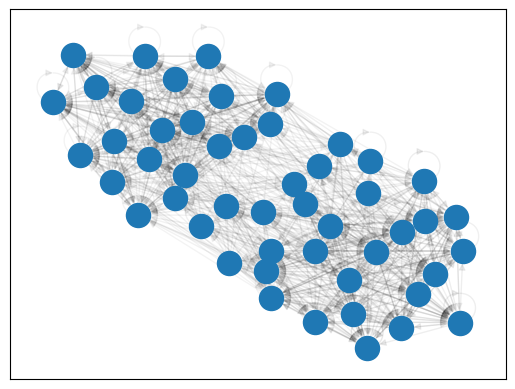

In [29]:
def real_graphon_sample(M, p, size):
    n, _ = M.shape
    labels = rng.choice(n, size=size, p=p)
    labels = torch.as_tensor(labels)
    index = labels[..., :, None] * M.stride(0) + labels[..., None, :]
    probas = M.view(-1)[index]
    sample = torch.rand_like(probas)<probas
    isolated_points = (sample == 0).all(-1, keepdim=True).expand_as(sample)
    sample[isolated_points] = torch.eye(size[-1], dtype=bool).expand_as(sample)[isolated_points] 
    sums = sample.sum(-1, keepdims = True)
    sample = sample / sample.sum(-1, keepdims=True)
    return labels, sample
    

graphon_probas = [.4, .4, .2]
#M = torch.rand((2, 2))
graphon = torch.as_tensor([
                    [.8, .15, .05], 
                    [.1, .7, .2],
                    [.3, .5, .2]])

labels, samples = real_graphon_sample(graphon, graphon_probas, (5, 50))


n_labels = len(graphon)

draw_markov(samples[0])
labels[0]

In [9]:
# test that our model performs as expected
# looks good

lotsa_labels, lotsa_matrices = real_graphon_sample(graphon, graphon_probas, (80, 50))

empiric_p = [ (lotsa_labels == i).to(float).mean().item() for i in range(n_labels)]

empiric_M = [[ 
    (lotsa_matrices[(lotsa_labels[:, :, None] == i) & (lotsa_labels[:, None, :] ==j)] != 0).to(float).mean().item()
    for j in range(n_labels)] for i in range(n_labels)]
(torch.as_tensor(empiric_p) - torch.as_tensor(graphon_probas))/torch.as_tensor(graphon_probas), (torch.as_tensor(empiric_M) - graphon)/ graphon

RuntimeError: The size of tensor a (5) must match the size of tensor b (3) at non-singleton dimension 0

In [57]:
def graph_model_sample(M):
    M_sampled = rng.random(M.shape) < M.numpy(force=True)
    return nx.from_numpy_array(M_sampled)

def graph_model_sample_markov(M):
    M_sampled = torch.rand_like(M)<M
    M_sampled = M_sampled / M_sampled.sum(-1)
    return M_sampled


p = .6
q1 = .1
q2 = .2

a = 5
b = 7
n = a + b

graphon = torch.ones((n, n), device=device) * q1
graphon[:a, :a] = pa
graphon[a:, a:] = p
graphon[a:, :a] = q2



sns.heatmap(graphon.numpy(force=True).T, vmax=1., vmin=0.)

NameError: name 'pa' is not defined

In [324]:
n_steps = 10000
heat=1.
matching_heat=1.
run_name=f"test_graphon{(n_run := vars().get('n_run', -1) + 1)}"

projection_size = n_labels
target_size=20
batch_size=15


projection = ParametricMarkovMatrixWithMatchings(projection_size, n_labels, heat=heat, matching_heat=matching_heat).to(device)
projection_measure_unsoftmaxed = torch.randn((1, projection_size,), device=device, requires_grad=True)
#projection_labels_unsoftmaxed = torch.randn((projection_size, label_size), device=device, requires_grad=True)


target_measure = torch.ones((1, target_size), device=device, requires_grad=False) / target_size
#target_measures_batched = torch.stack(target_measures, dim=0)

wl_parameters = dict(delta=.2, sinkhorn_reg=.01)

optim = torch.optim.SGD([*projection.parameters(), projection_measure_unsoftmaxed], lr=5e-3, weight_decay=0)

writer = SummaryWriter(f"{os.environ['HOME']}/tensorboard/{run_name}")
parameter_values = []
losses = []
for step in trange(n_steps):
    optim.zero_grad()
    sample_labels, samples = real_graphon_sample(graphon, graphon_probas, (batch_size, target_size))
    samples = samples.to(device); sample_labels = sample_labels.to(device) #b, target_size, target_size #b, target_size



    Markov_matrix, label_neg_likelihood = projection() # (projection_size, projection_size) and (projection_size, n_labels)
    # though in this case projection_size = n_labels
    measure = F.softmax(projection_measure_unsoftmaxed, dim=-1)

    label_neg_likelihood = label_neg_likelihood[None, :, None, :].expand(batch_size, projection_size, target_size, n_labels) # (b, p_size, target_size, n_labels)
    sample_labels = sample_labels[:, None, :, None].expand(batch_size, projection_size, target_size, 1) #b, p_size, target_size, 1

    D = label_neg_likelihood.gather(-1, sample_labels).squeeze(-1) #b, p_size, target_size
    # D[b, i, j, 0] = label_neg_likelihood[b, i, j, sample_labels[b, i, j, 0]] = label_neg_likelihood_previous[i, sample_labels[b, j]] = -log( p( l_i == l_bj)) 

    batched_M = Markov_matrix.expand(batch_size, -1, -1)

    loss = wl_reg_infty(batched_M, 
                        samples, 
                        D, 
                        muX=measure,
                        muY=target_measure,
                        **wl_parameters).square().mean(0)

    #log stuff

    writer.add_scalar("loss", loss, step) 
    losses.append(loss.item())
    with torch.no_grad():
        markov, *matchings = projection.get()
        parameter_values.append(
            (markov.numpy(force=True), 
             *(matching.detach().cpu() for matching in matchings),
             measure.numpy(force=True)
            )
        )

    #step
    loss.backward()
    optim.step()



  0%|          | 0/10000 [00:00<?, ?it/s]

In [325]:
markov, labels, probas = parameter_values[-1]

max_corres = labels.argmax(axis=-1)
permutation = np.zeros((n_labels, n_labels))
permutation[np.arange(n_labels), max_corres] = 1
if np.linalg.det(permutation) != 0:
    markov = permutation.T @ markov @ permutation
    labels = permutation.T @ labels.numpy(force=True)
    probas =  probas @ permutation

In [326]:
label_names = [f"l{i}" for i in range(3)]
state_names = [f"s{i}" for i in range(3)]

[Text(0.5, 1.0, 'graphon probabilities'),
 Text(767.7810457516341, 0.5, 'label')]

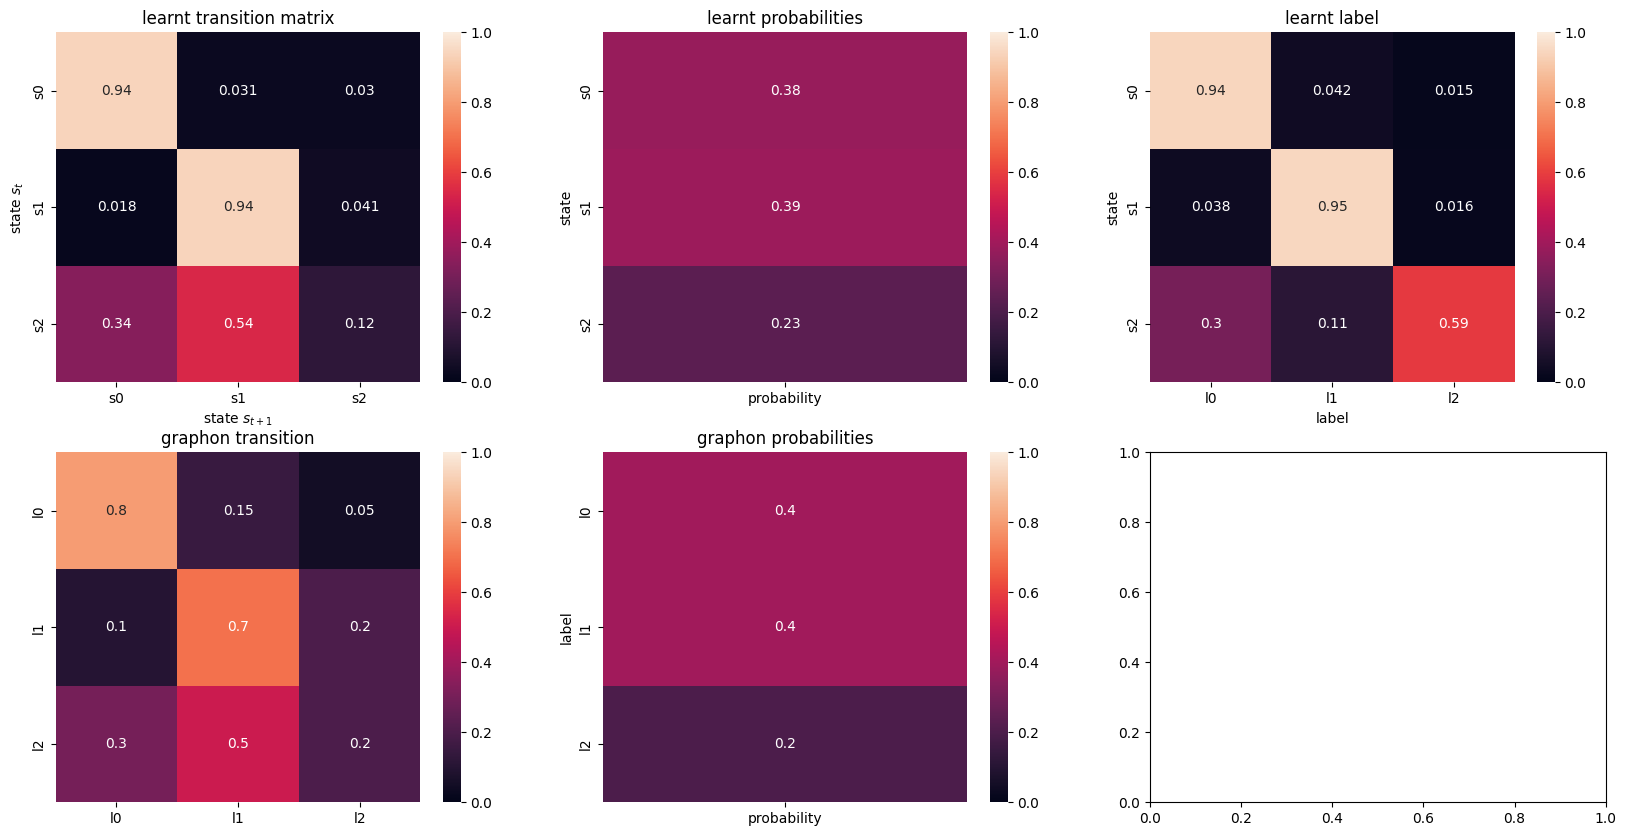

In [327]:
_, axes = plt.subplots(2, 3, figsize=(20, 10))

axes_iter = iter(axes.flat)

ax = next(axes_iter)
sns.heatmap(markov, vmin=0, vmax=1, xticklabels=state_names, yticklabels=state_names, annot=True, ax=ax)
ax.set(title="learnt transition matrix", ylabel="state $s_t$", xlabel="state $s_{t+1}$")                    

ax = next(axes_iter)
sns.heatmap(probas.T, vmin=0, vmax=1, yticklabels=state_names, xticklabels=["probability"], annot=True, ax=ax)
ax.set(title="learnt probabilities", ylabel="state")                    

ax = next(axes_iter)
sns.heatmap(labels, vmin=0, vmax=1,xticklabels=label_names, yticklabels=state_names, annot=True, ax=ax)
ax.set(title="learnt label", ylabel="state", xlabel="label")                    

ax = next(axes_iter)
ax.set_title("graphon transition")
sns.heatmap(graphon, vmin=0, vmax=1, xticklabels=label_names, yticklabels=label_names, annot=True, ax=ax)

ax = next(axes_iter)
sns.heatmap(np.array(graphon_probas)[:, None], xticklabels=["probability"], yticklabels=label_names, vmin=0, vmax=1, annot=True, ax=ax)
ax.set(title="graphon probabilities", ylabel="label")                    


In [267]:
best_parameter_values = parameter_values
%store best_parameter_values

Stored 'best_parameter_values' (list)


In [217]:
permutation @ labels

array([[0.50106198, 0.10398546, 0.39495257],
       [0.04358172, 0.79087538, 0.16554287],
       [0.1140869 , 0.08060992, 0.80530316]])

# Let’s do states in `[0, 1]` like the usual model and uniform probas

In [45]:
graphon

tensor([[0.8000, 0.1500, 0.0500],
        [0.1000, 0.7000, 0.2000],
        [0.3000, 0.5000, 0.2000]])

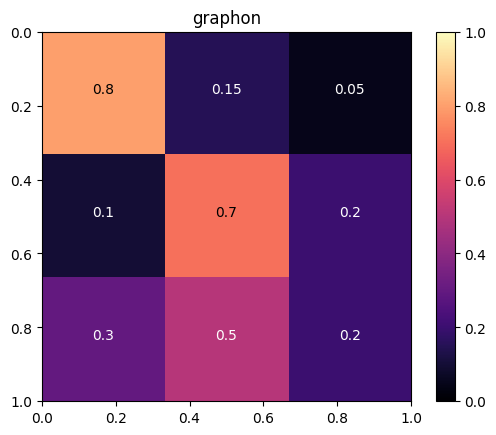

In [117]:
import matplotlib as mpl

mpl.rc("image", cmap="magma")

def new_graphon_show(graphon):
    extent = [0, 1, 1, 0]
    plt.imshow(graphon, vmin=0, vmax=1, origin="upper", extent=extent)
    ax=plt.gca()
    for (i, x), (j, y) in it.product(enumerate(np.linspace(0, 1, num=n_labels, endpoint=False)), repeat=2):
        ax.text(x + 1 / (2*n_labels), (y + 1/(2*n_labels)), 
                f"{graphon[j, i].item():.02}", 
                ha="center",
               color = "black" if graphon[i,j].item() > .5 else "white")
    plt.colorbar();
    plt.title("graphon")
new_graphon_show(graphon)

In [49]:
torch.floor(graphon).to(int)

tensor([[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]])

In [73]:
def new_graphon_sample(M, size):
    n, _ = M.shape
    if isinstance(size, int):
        size = size,
    labels = rng.random(size=size)
    labels = torch.as_tensor(labels).to(torch.float32)
    int_labels = torch.floor(labels * n).to(int)
    index = int_labels[..., :, None] * M.stride(0) + int_labels[..., None, :]
    probas = M.view(-1)[index]
    sample = torch.rand_like(probas)<probas
    isolated_points = (sample == 0).all(-1, keepdim=True).expand_as(sample)
    sample[isolated_points] = torch.eye(size[-1], dtype=bool).expand_as(sample)[isolated_points] 
    sums = sample.sum(-1, keepdims = True)
    sample = sample / sample.sum(-1, keepdims=True)
    return labels, sample

sampled_labels, sampled_graph = new_graphon_sample(graphon, 100)
#draw_markov(sampled_graph)

In [75]:
sampled_labels.dtype
sampled_graph.dtype

torch.float32

In [141]:
n_steps = 2023
heat=1.
matching_heat=1.
run_name=f"test_graphon{(n_run := vars().get('n_run', -1) + 1)}"

projection_size = n_labels
target_size=20
batch_size=30


projection = ParametricMarkovMatrixWithLabels(projection_size, 1, heat=heat).to(device)
projection_measure = torch.ones((1, projection_size), device=device, 
                                requires_grad=False) / projection_size
target_measure = torch.ones((1, target_size), device=device, 
                            requires_grad=False) / target_size

wl_parameters = dict(delta=.2, sinkhorn_reg=.01, x_is_sparse=False, y_is_sparse=True)

optim = torch.optim.SGD(projection.parameters(), lr=1e-3, weight_decay=0)

writer = SummaryWriter(f"{os.environ['HOME']}/tensorboard/{run_name}")
parameter_values = []
losses = []
for step in trange(n_steps):
    optim.zero_grad()
    sample_labels, samples = new_graphon_sample(graphon, (batch_size, target_size))
    samples = samples.to(device); sample_labels = sample_labels.to(device) #b, target_size, target_size #b, target_size



    Markov_matrix, labels = projection() # (projection_size, projection_size) and (projection_size, n_labels)
    # though in this case projection_size = n_labels
    #labels (nx, 1)
    #sample_labels (batch, ny)
    D = (labels[None, :, :] - sample_labels[:, None, :]).abs()
    #D (batch, nx, ny)
    batched_M = Markov_matrix.expand(batch_size, -1, -1)
    loss = wl_reg_infty(batched_M, 
                        samples, 
                        D, 
                        muX=projection_measure,
                        muY=target_measure,
                        **wl_parameters).mean(0)

    #log stuff

    writer.add_scalar("loss", loss, step) 
    losses.append(loss.item())
    with torch.no_grad():
        markov, *matchings = projection.get()
        parameter_values.append(
            (markov.numpy(force=True), 
             *(matching.detach().cpu() for matching in matchings),
            )
        )

    #step
    loss.backward()
    optim.step()



  0%|          | 0/2023 [00:00<?, ?it/s]

In [142]:
markov, labels = projection.get()
markov = markov.numpy(force=True)
labels = labels.numpy(force=True).squeeze()

order = np.argsort(labels)
#labels = labels[order]
#markov = markov[order, :][:, order]

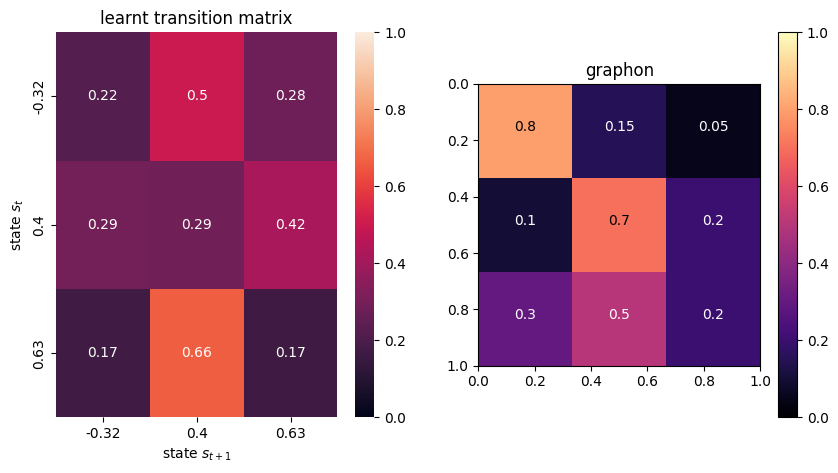

In [143]:
_, axes = plt.subplots(1, 2, figsize=(10, 5))

axes_iter = iter(axes.flat)

labels_truncated = [f"{l:.02}" for l in labels]

ax = next(axes_iter)
sns.heatmap(markov, vmin=0, vmax=1, xticklabels=labels_truncated, yticklabels=labels_truncated, annot=True, ax=ax)
ax.set(title="learnt transition matrix", ylabel="state $s_t$", xlabel="state $s_{t+1}$")                    

ax = next(axes_iter)
ax.set_title("graphon transition")
plt.sca(ax)
new_graphon_show(graphon)
